In [587]:
get_ipython().system('pip install hurst fbprophet matplotlib yfinance numpy statsmodels datetime pandas_market_calendars')


/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [588]:


import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date
import pandas_ta as ta
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc
from fbprophet import Prophet
import pandas_market_calendars as mcal
from finta import TA

import os.path
from os import path

from scipy.stats import ttest_ind
from numpy import cumsum

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely


In [589]:


n_forward = 7
#name = 'BTC-USD'
#name = 'GLD'
name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
#end_date = datetime.date.today()
end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)
start_date = end_date1 - timedelta(weeks=w)


In [590]:
cores = int(len(os.sched_getaffinity(0)))

nyse = mcal.get_calendar('NYSE')
nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+3)))

ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date, auto_adjust=True)
data['Forward Close'] = data['Close'].shift(-n_forward)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']
data['VWP'] = data['Close']*data['Volume']

Short_EVWMA = pd.DataFrame(TA.EVWMA(data,12))
Long_EVWMA = pd.DataFrame(TA.EVWMA(data,26))
Short_EVWMA.columns = ['EVWMA_12']
Long_EVWMA.columns = ['EVWMA_26']

#p 209 of ttr doc
MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/(Long_EVWMA['EVWMA_26']))
MACD_EVWMA.columns = ['MACD-line']

Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
data['MACD_Signal'] = Signal_EVWMA

benchName = "^GSPC"
bench = yfinance.Ticker(benchName)
benchData = bench.history(interval="1d",start=start_date,end=end_date, auto_adjust=True)
len(benchData)
len(data)



/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



1130

In [591]:
width2

565

In [592]:


dateindex = data.loc[start_date:end_date].index

dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]




In [593]:

if(len(data)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0).index
    
else:
    frequency=nyse_trading_dates.reset_index().set_index('index').rename_axis([None]).index

#https://stackoverflow.com/questions/40815238/python-pandas-convert-index-to-datetime
#frequency = pd.to_datetime(frequency, errors='coerce')


In [594]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)

for d in prices.rename_axis([None]).index:
    df.loc[d] = prices.loc[d]

df.interpolate(method='linear')

benchData = df[start_date:end_date]


Open    High     Low   Close     Volume  Dividends  \
Date                                                               
2014-06-16  169.92  170.63  169.72  170.27   87424000      0.000   
2014-06-17  170.04  170.87  169.85  170.75   84834000      0.000   
2014-06-18  170.75  172.10  170.37  172.00  105267000      0.000   
2014-06-19  172.15  172.30  171.60  172.19   85929000      0.000   
2014-06-20  172.62  172.68  172.33  172.54  100587000      0.937   
2014-06-23  172.59  172.64  172.17  172.49   70611000      0.000   
2014-06-24  172.18  173.03  171.26  171.45   96237000      0.000   
2014-06-25  171.09  172.40  171.05  172.22   82782000      0.000   
2014-06-26  172.25  172.27  170.95  172.10   84312000      0.000   
2014-06-27  171.70  172.49  171.62  172.44   71445100      0.000   
2014-06-30  172.33  172.74  172.18  172.35   70201200      0.000   
2014-07-01  172.77  174.03  172.71  173.50   90470000      0.000   
2014-07-02  173.52  173.90  173.44  173.68   52475000      0.000   
2014-07-03  174.17  174.61  174.04  174.53   52938800      0.000   
2014-07-07  174.20  174.34  173.67  173.92   61696000      0.000   
2014-07-08  173.61  173.67  172.38  172.81  108143000      0.000   
2014-07-09  173.24  173.74  172.87  173.58   72992000      0.000   
2014-07-10  171.91  173.35  171.77  172.89   99040000      0.000   
2014-07-11  172.79  173.25  172.40  173.13   64243000      0.000   
2014-07-14  174.01  174.23  173.86  174.00   58658000      0.000   
2014-07-15  174.11  174.44  172.91  173.68  111307000      0.000   
2014-07-16  174.45  174.58  173.84  174.32   79986400      0.000   
2014-07-17  173.78  174.44  172.09  172.34  145398000      0.000   
2014-07-18  172.90  174.28  172.81  174.10  124330000      0.000   
2014-07-21  173.55  173.91  172.97  173.77   67592000      0.000   
2014-07-22  174.36  174.85  174.24  174.53   67678000      0.000   
2014-07-23  174.80  175.10  174.44  174.92   65612000      0.000   
2014-07-24  175.09  175.29  174.75  174.93   56888000      0.000   
2014-07-25  174.43  174.58  173.77  174.11   76837000      0.000   
2014-07-28  174.14  174.43  173.14  174.18   69259000      0.000   
2014-07-29  174.50  174.75  173.40  173.43   80466000      0.000   
2014-07-30  174.05  174.28  172.73  173.46  104222000      0.000   
2014-07-31  172.25  172.40  169.93  170.03  183479000      0.000   
2014-08-01  169.56  170.62  168.69  169.51  189261000      0.000   
2014-08-04  169.84  171.10  169.12  170.74   91340000      0.000   
2014-08-05  170.04  170.48  168.46  169.08  152690000      0.000   
2014-08-06  168.29  169.86  168.26  169.13   94818000      0.000   
2014-08-07  169.90  170.07  167.79  168.22  135733000      0.000   
2014-08-08  168.60  170.28  168.15  170.16  117014000      0.000   
2014-08-11  170.81  171.41  170.58  170.66   74544000      0.000   
2014-08-12  170.49  170.96  169.90  170.42   73632000      0.000   
2014-08-13  171.09  171.77  170.80  171.57   69047000      0.000   
2014-08-14  171.85  172.38  171.70  172.38   57371000      0.000   
2014-08-15  173.01  173.17  171.11  172.35  139951000      0.000   
2014-08-18  173.30  173.87  173.20  173.79   75424000      0.000   
2014-08-19  174.21  174.83  173.86  174.70   59135000      0.000   
2014-08-20  174.46  175.38  174.43  175.17   72763000      0.000   
2014-08-21  175.32  175.91  175.17  175.68   67791000      0.000   
2014-08-22  175.54  175.84  175.01  175.40   76107000      0.000   
2014-08-25  176.24  176.64  175.37  176.29   63855000      0.000   
2014-08-26  176.41  176.84  176.36  176.41   47298000      0.000   
2014-08-27  176.50  176.62  176.06  176.34   47874000      0.000   
2014-08-28  175.76  176.35  175.58  176.24   58330000      0.000   
2014-08-29  176.51  176.76  175.96  176.74   65907000      0.000   
2014-09-02  176.97  177.00  175.99  176.65   72426000      0.000   
2014-09-03  177.33  177.36  176.31  176.56   57462000      0.000   
2014-09-04  176.86  177.51  175.82  176.30   85236000      0.000   
20

In [595]:

#prices = data.loc[~data.index.duplicated(keep='last')]        
#prices = data.reset_index()

#idx1 = prices.index  
#idx1 = pd.to_datetime(idx1, errors='coerce')

#merged = idx1.union(idx2)
#s = prices.reindex(merged)
#df = s.interpolate(method='linear').dropna(axis=0, how='any')

prices = data.loc[~data.index.duplicated(keep='last')]        

df = prices.rename_axis([None]).reindex(frequency)

for d in prices.rename_axis([None]).index:
    df.loc[d] = prices.loc[d]

df.interpolate(method='linear').dropna(axis=0, how='any')

data=df

In [596]:
frequency

DatetimeIndex(['2014-06-16', '2014-06-17', '2014-06-18', '2014-06-19',
               '2014-06-20', '2014-06-23', '2014-06-24', '2014-06-25',
               '2014-06-26', '2014-06-27',
               ...
               '2018-12-06', '2018-12-07', '2018-12-10', '2018-12-11',
               '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-17',
               '2018-12-18', '2018-12-19'],
              dtype='datetime64[ns]', length=1138, freq=None)

In [597]:
i = range(0,width1)[-1]
temp = data.loc[frequency[i]:frequency[i+width2]].copy() 
temp

Open    High     Low   Close       Volume  Dividends  \
2016-09-09  199.04  199.10  195.63  195.66  221589100.0      0.000   
2016-09-12  194.84  198.89  194.77  198.46  168110900.0      0.000   
2016-09-13  197.09  197.37  194.94  195.61  182828800.0      0.000   
2016-09-14  195.67  196.96  194.94  195.54  134185500.0      0.000   
2016-09-15  195.36  197.90  195.17  197.49  134427900.0      0.000   
2016-09-16  196.83  197.02  195.99  196.73  155236400.0      1.082   
2016-09-19  197.43  198.12  196.41  196.76   80250500.0      0.000   
2016-09-20  197.69  197.85  196.74  196.77   69665300.0      0.000   
2016-09-21  197.53  199.18  196.79  198.99  110284400.0      0.000   
2016-09-22  200.07  200.56  199.81  200.24   76678700.0      0.000   
2016-09-23  199.82  199.96  199.04  199.14   73630900.0      0.000   
2016-09-26  198.25  198.44  197.32  197.53   89827300.0      0.000   
2016-09-27  197.35  198.86  196.96  198.76   78494800.0      0.000   
2016-09-28  199.00  199.91  197.96  199.74   87411000.0      0.000   
2016-09-29  199.52  199.95  197.34  197.94  128070600.0      0.000   
2016-09-30  198.83  200.18  198.56  199.43  117202900.0      0.000   
2016-10-03  198.99  199.19  198.27  198.95   83512100.0      0.000   
2016-10-04  199.07  199.31  197.30  197.94  119948100.0      0.000   
2016-10-05  198.61  199.27  198.53  198.81   72816000.0      0.000   
2016-10-06  198.57  199.19  197.99  198.95   62927400.0      0.000   
2016-10-07  199.24  199.43  197.48  198.27   89788300.0      0.000   
2016-10-10  199.30  199.80  199.14  199.30   51855000.0      0.000   
2016-10-11  198.84  198.91  196.00  196.78  130367400.0      0.000   
2016-10-12  196.93  197.60  196.40  197.04   73866100.0      0.000   
2016-10-13  195.61  196.93  194.74  196.40  101357000.0      0.000   
2016-10-14  197.45  197.94  196.41  196.50   93346200.0      0.000   
2016-10-17  196.47  196.75  195.62  195.81   58275700.0      0.000   
2016-10-18  197.53  197.59  196.64  197.04   76869700.0      0.000   
2016-10-19  197.33  197.90  196.94  197.57   66519200.0      0.000   
2016-10-20  197.19  197.80  196.49  197.20   73639800.0      0.000   
2016-10-21  197.20  197.38  196.16  197.29   89089100.0      0.000   
2016-10-24  198.23  198.53  197.75  198.13   60146600.0      0.000   
2016-10-25  197.94  198.21  197.29  197.46   66542300.0      0.000   
2016-10-26  196.58  197.70  196.32  197.07   75705500.0      0.000   
2016-10-27  197.84  197.88  196.46  196.54   77220200.0      0.000   
2016-10-28  196.52  197.24  195.20  195.96  140623200.0      0.000   
2016-10-31  196.32  196.56  195.80  195.97   61272500.0      0.000   
2016-11-01  196.32  196.38  193.25  194.55  122781800.0      0.000   
2016-11-02  194.22  194.63  192.91  193.38  103330800.0      0.000   
2016-11-03  193.61  193.84  192.20  192.50   88939300.0      0.000   
2016-11-04  192.62  193.52  192.13  192.28  109122100.0      0.000   
2016-11-07  192.28  196.56  192.28  196.52  109794900.0      0.000   
2016-11-08  196.10  198.02  195.81  197.41  106772100.0      0.000   
2016-11-09  195.81  200.17  195.78  199.50  258429000.0      0.000   
2016-11-10  200.35  201.28  198.43  200.00  172113300.0      0.000   
2016-11-11  199.23  199.80  198.53  199.54  100552700.0      0.000   
2016-11-14  200.10  200.32  198.89  199.70   94580000.0      0.000   
2016-11-15  200.11  201.25  199.89  201.25   91652600.0      0.000   
2016-11-16  200.59  201.13  200.46  200.88   65617700.0      0.000   
2016-11-17  201.04  201.97  200.92  201.91   69797200.0      0.000   
2016-11-18  201.98  202.17  201.26  201.46   86265800.0      0.000   
2016-11-21  202.07  203.01  201.92  202.98   72402600.0      0.000   
2016-11-22  203.31  203.57  202.59  203.37   67429000.0      0.000   
2016-11-23  202.82  203.54  202.61  203.49   56620200.0      0.000   
2016-11-25  203.85  204.28  203.77  204.24   37872300.0      0.000   
2016-11-28  203.91  204.20  203.17  203.28   76572500.0      0.000   
2016-11-29  203.32  204.

In [598]:
#dateToBeSold
#dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1].strftime('%Y-%m-%d'), "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
temp.index[-1]

Timestamp('2018-12-07 00:00:00')

In [601]:

limit = 100

train_size = 0.5

minExpectedReturn = 0

width1 = len(benchData.loc[start_date:end_date1].index)
#len(data.loc[start_date:end_date1].index)
width2 = len(benchData.loc[end_date1+timedelta(days=1):end_date].index)
#len(data.loc[end_date1+timedelta(days=1):end_date].index)

#for i in range(0,width1):
#for i in [range(0,width1)[-1]]:
def processSet(i):
    trades2 = pd.DataFrame()
    
    temp = data.loc[frequency[i]:frequency[i+width2]].copy()        

    innerIndicator = 'Close'
    #not sure if kind should be price
    adf_results = ts.adfuller(temp[innerIndicator], 1)
    
    #makes no sense to do with n_forward
    H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)            
    
    fb = True
    
    if fb:        
        
        ts1 = pd.DataFrame()
        ts1["Date"] = temp.index
        ts1['y'] = temp[innerIndicator].values
        ts1.columns = ['ds', 'y']

        #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
        m = Prophet(daily_seasonality=True,yearly_seasonality=True)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
        m.fit(ts1)

        #forecast only last day in model (can verify result) needs to be based on df.loc (similar to df_inner)
        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1].strftime('%Y-%m-%d'), "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
        nextDay = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1].strftime('%Y-%m-%d'), "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')
        forecast = pd.DataFrame(pd.DataFrame(frequency)[0][(pd.DataFrame(frequency)[0] <= datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()) & (pd.DataFrame(frequency)[0] >= datetime.datetime.strptime(nextDay, "%Y-%m-%d").date())])
        forecast.columns = ['ds']

        #Predict and plot
        pred = m.predict(forecast)['yhat']
        pred = pd.DataFrame(pred)
        pred.columns = [innerIndicator]
        
    result = []
    
    for ma_length in range(20,limit):        
        
        if strategy == "EMA":
            
            temp[strategy] = ta.ema(temp[indicator], length=ma_length)
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
            
        elif strategy == "SMA":
            
            temp[strategy] = temp[indicator].rolling(ma_length).mean()
            temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]
                
        df = temp.dropna()
        
        training = df.head(int(train_size * df.shape[0]))
        test = df.tail(int((1 - train_size) * df.shape[0]))
        
        tr_returns = training[training['input'] == 1]['Forward Return']
        test_returns = test[test['input'] == 1]['Forward Return']
        
        mean_forward_return_training = tr_returns.mean()
        mean_forward_return_test = test_returns.mean()
        pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

        result.append({
            'ma_length':ma_length,
            'training_forward_return': mean_forward_return_training,
            'test_forward_return': mean_forward_return_test,
            'p-value':pvalue
        })
    
    result.sort(key = lambda x : -x['training_forward_return'])
    
    if strategy == "EMA":
        temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])
        
    elif strategy == "SMA":
        temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()    
    
    #conditions = 0
    
    if fb:
        
        predRet = (pred.iloc[-1][0] - temp.iloc[-1][innerIndicator])/temp.iloc[-1][innerIndicator]
        #print(predRet)
        
        if predRet >= 0:
            
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['fbProphet']
            trade['expRet'] = predRet
            trades2 = pd.concat([trades2,trade])

    
    if temp.iloc[-1]['MACD_Signal'] > 0:
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['MACD']
            trade['expRet'] = [temp.iloc[-1]['MACD_Signal']]
            trades2 = pd.concat([trades2,trade])
            
    #if(n_forward > 1):
        
        #fit2 = Holt(temp['MACD_Signal'], exponential=False, initialization_method="estimated").fit(optimized=True)
        #fcast2 = fit2.forecast(n_forward).rename("Exponential trend")    
        
        #if(fcast2[-1] >= .02):
            #conditions = conditions + 1
      
    #elif (temp.iloc[-1]['MACD_Signal'] >= .02):
        #conditions = conditions + 1
        
    if (H > 0.5):
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['H']
            trade['expRet'] = [H]
            trade['sdev'] = ['']
            trades2 = pd.concat([trades2,trade])

    if (adf_results[1] > 0.05):
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = ['adf']
            trade['expRet'] = [adf_results[1]]
            trade['sdev'] = ['']
            trades2 = pd.concat([trades2,trade])
        
    if (result[0]['p-value'] > .05 and temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):
                
        if (result[0]['training_forward_return'] > minExpectedReturn and result[0]['test_forward_return'] > minExpectedReturn):
            
            trade = pd.DataFrame()
            trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
            trade['Type'] = [strategy]
            trade['expRet'] = [((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)]
            trade['sdev'] = [np.std(temp['Forward Return'])]
            trades2 = pd.concat([trades2,trade])

            if fb:

                if predRet >= 0:

                    trade = pd.DataFrame()
                    trade['Date'] = [temp.index[-1].strftime('%Y-%m-%d')]
                    trade['Type'] = ['fbProphet+strategy']
                    trade['expRet'] = [(predRet + ((result[0]['training_forward_return']+result[0]['test_forward_return'])/2))/2]
                    trade['sdev'] = ['']
                    trades2 = pd.concat([trades2,trade])

    #print(trades2)
    return trades2

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

futures1 = [pool1.submit(processSet, args) for args in range(0,width1)]

wait(futures1, timeout=None, return_when=ALL_COMPLETED)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
beh

DoneAndNotDoneFutures(done={<Future at 0x7f919c9a0048 state=finished returned DataFrame>, <Future at 0x7f91d68280b8 state=finished returned DataFrame>, <Future at 0x7f9196c480f0 state=finished returned DataFrame>, <Future at 0x7f91d69b80f0 state=finished returned DataFrame>, <Future at 0x7f91d68280f0 state=finished returned DataFrame>, <Future at 0x7f91d69b8128 state=finished returned DataFrame>, <Future at 0x7f919c9a0160 state=finished returned DataFrame>, <Future at 0x7f91d69b81d0 state=finished returned DataFrame>, <Future at 0x7f91d69b8208 state=finished returned DataFrame>, <Future at 0x7f91d6828208 state=finished returned DataFrame>, <Future at 0x7f919c9a0208 state=finished returned DataFrame>, <Future at 0x7f91d69b8240 state=finished returned DataFrame>, <Future at 0x7f9197218278 state=finished returned DataFrame>, <Future at 0x7f9196c482b0 state=finished returned DataFrame>, <Future at 0x7f91d69b82b0 state=finished returned DataFrame>, <Future at 0x7f9196c482e8 state=finished r

In [602]:
trades2 = pd.DataFrame()

for f in futures1:
    #throwing a weird date error with one dataframe (had date outside of range)
    #rint(f.result())
    trades2 = pd.concat([trades2,f.result()])
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [603]:
trades2

Date                Type    expRet      sdev
0  2016-09-12           fbProphet  0.014779       NaN
0  2016-09-12                MACD  0.012162       NaN
0  2016-09-12                 adf  0.163696       NaN
0  2016-09-12                 SMA  0.008513  0.022004
0  2016-09-12  fbProphet+strategy  0.011646       NaN
0  2016-09-13           fbProphet  0.022113       NaN
0  2016-09-13                MACD  0.011061       NaN
0  2016-09-13                 adf  0.130564       NaN
0  2016-09-13                 SMA  0.008351  0.022020
0  2016-09-13  fbProphet+strategy  0.015232       NaN
0  2016-09-14           fbProphet  0.014568       NaN
0  2016-09-14                MACD  0.009978       NaN
0  2016-09-14                 adf  0.142798       NaN
0  2016-09-14                 SMA  0.008133  0.022029
0  2016-09-14  fbProphet+strategy  0.011351       NaN
0  2016-09-15           fbProphet  0.000208       NaN
0  2016-09-15                MACD  0.009021       NaN
0  2016-09-15                 adf  0.167733       NaN
0  2016-09-15                 SMA  0.008143  0.022029
0  2016-09-15  fbProphet+strategy  0.004175       NaN
0  2016-09-16           fbProphet  0.003167       NaN
0  2016-09-16                MACD  0.008135       NaN
0  2016-09-16                 adf  0.160711       NaN
0  2016-09-16                 SMA  0.008376  0.022032
0  2016-09-16  fbProphet+strategy  0.005772       NaN
0  2016-09-19           fbProphet  0.006227       NaN
0  2016-09-19                MACD  0.007370       NaN
0  2016-09-19                 adf  0.159934       NaN
0  2016-09-20           fbProphet  0.008475       NaN
0  2016-09-20                MACD  0.006712       NaN
0  2016-09-20                 adf  0.147698       NaN
0  2016-09-21                MACD  0.006188       NaN
0  2016-09-21                 adf  0.187131       NaN
0  2016-09-21                 SMA  0.008350  0.022028
0  2016-09-22           fbProphet  0.003076       NaN
0  2016-09-22                MACD  0.005794       NaN
0  2016-09-22                 adf  0.207117       NaN
0  2016-09-23           fbProphet  0.011520       NaN
0  2016-09-23                MACD  0.005478       NaN
0  2016-09-23                 adf  0.191173       NaN
0  2016-09-26           fbProphet  0.028674       NaN
0  2016-09-26                MACD  0.005182       NaN
0  2016-09-26                 adf  0.164355       NaN
0  2016-09-27           fbProphet  0.022403       NaN
0  2016-09-27                MACD  0.004941       NaN
0  2016-09-27                 adf  0.195976       NaN
0  2016-09-28           fbProphet  0.020017       NaN
0  2016-09-28                MACD  0.004780       NaN
0  2016-09-28                 adf  0.215092       NaN
0  2016-09-29           fbProphet  0.030154       NaN
0  2016-09-29                MACD  0.004598       NaN
0  2016-09-29                 adf  0.193522       NaN
0  2016-09-29                 SMA  0.008297  0.022034
0  2016-09-29  fbProphet+strategy  0.019225       NaN
0  2016-09-30           fbProphet  0.022261       NaN
0  2016-09-30                MACD  0.004489       NaN
0  2016-09-30                 adf  0.210805       NaN
0  2016-09-30                 SMA  0.008043  0.022042
0  2016-09-30  fbProphet+strategy  0.015152       NaN
0  2016-10-03           fbProphet  0.026593       NaN
0  2016-10-03                MACD  0.004405       NaN
0  2016-10-03                 adf  0.189181       NaN
0  2016-10-04           fbProphet  0.033354       NaN
0  2016-10-04                MACD  0.004277       NaN
0  2016-10-04                 adf  0.182328       NaN
0  2016-10-04                 SMA  0.008137  0.022050
0  2016-10-04  fbProphet+strategy  0.020745       NaN
0  2016-10-05           fbProphet  0.030170       NaN
0  2016-10-05                MACD  0.004175       NaN
0  2016-10-05                 adf  0.186833       NaN
0  2016-10-06           fbProphet  0.037649       NaN
0  2016-10-06                MACD  0.004098       NaN
0  2016-10-06                 adf  0.191592       NaN
0  2016-10-07

In [604]:
len(trades2[trades2['Type']=='fbProphet+strategy'])

113

(array([12., 26., 19., 21., 15.,  9.,  4.,  3.,  2.,  0.,  1.,  1.]),
 array([0.0029094 , 0.00656705, 0.01022469, 0.01388234, 0.01753999,
        0.02119764, 0.02485529, 0.02851293, 0.03217058, 0.03582823,
        0.03948588, 0.04314353, 0.04680118]),
 <a list of 12 Patch objects>)

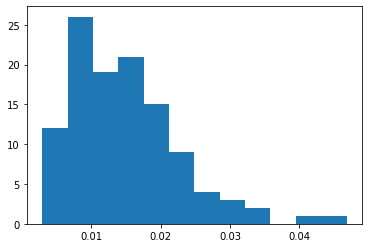

In [605]:
#trades2[trades2['Type']=='fbProphet']
#trades2.Type.unique()
#

plt.hist(trades2[trades2['Type']=='fbProphet+strategy']['expRet'], bins='auto')  # arguments are passed to np.histogram

In [606]:


set = pd.DataFrame()
for i in range(0,len(trades2)):
    value = pd.DataFrame(data.loc[trades2.iloc[i]['Date']]).transpose().reset_index(drop=True)
    value['index'] = i
    value['type'] = trades2.iloc[i]['Type']
    value['Date'] = trades2.iloc[i]['Date']
    value['ExpectedReturn'] = [trades2.iloc[i]['expRet']]
    value['sdev'] = trades2.iloc[i]['sdev']
    set = pd.concat([set,value.set_index('index')])




In [607]:

orderbook = pd.DataFrame()

#temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
column_names = ["date", "qty"]

sellDates = pd.DataFrame(columns = column_names)

#set[dateindex2[1].strftime('%Y-%m-%d')]
for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    idate = i.strftime('%Y-%m-%d')        
    
    #process purchases
    if (idate in set.set_index('Date').index):
        
        #innerSet = pd.DataFrame(set.set_index('Date').loc[idate]).transpose()
        innerSet = set.set_index('Date').loc[idate]
        
        #if isinstance(innerSet, pd.DataFrame):
            #print("pd")
        if isinstance(innerSet, pd.Series):
            #print("series")
            innerSet = pd.DataFrame(innerSet).transpose()

        #print(innerSet)
        types = innerSet.type.unique()
        #display(innerSet)

        for t in types:
            innerSet_t = innerSet[innerSet['type']==t]
            #print(innerSet[innerSet['type']==t])
            #print(innerSet_t)

            temp = pd.DataFrame()

            #estRet = set.set_index('Date').loc[idate]['ExpectedReturn']
            estRet = innerSet_t.loc[idate]['ExpectedReturn']

            temp['orderside'] = ['buy']        

            #if len(data[start_date:idate])-1+n_forward>=len(data[start_date:]):
                #dateToBesold = np.nan    
                #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                #temp['valueAtSale'] = np.nan
            #else:

            if (innerSet_t['type'][0] == strategy) or (innerSet_t['type'][0] == 'fbProphet') or (innerSet_t['type'][0]=='fbProphet+strategy'):
                #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
                dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
                #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
            else:
                dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')

            #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
            if dateToBeSold in data.index:
                temp['valueAtSale'] = data.loc[dateToBeSold]['Close']
            else:
                temp['valueAtSale'] = np.nan

            #temp['valueAtSale'] = data.loc[dateToBeSold]['Close']

            temp['date'] = [idate]
            temp['valueAtPurchase'] = innerSet_t['Close'][0]
            temp['estRet'] = estRet
            temp['type'] = t
            #innerSet_t['type'][0]
            #temp['qty'] = Qty
            temp['dateBought'] = idate        
            temp['dateToBeSold'] = dateToBeSold

            btemp = pd.DataFrame(columns = column_names)
            btemp["date"]=[dateToBeSold]
            btemp["type"]=t
            #btemp["qty"]=[Qty]

            sellDates = sellDates.append(btemp,ignore_index=True)

            temp = temp.round(4)

            orderbook = orderbook.append(temp,ignore_index=True)
        
        

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [608]:
(orderbook[orderbook['type']=='SMA']['valueAtSale']>orderbook[orderbook['type']=='SMA']['valueAtPurchase']).agg("mean")

0.7134502923976608

In [609]:

#for i in dateindex2:
for i in sellDates.sort_values(by=['date'], ascending=True)['date'].unique():
#sellDates.set_index('date').index:
    
    idate = i
    #.strftime('%Y-%m-%d')        
    
    #process sales
        
    #if (idate in sellDates.set_index('date').index): 

    dateTypes = sellDates.set_index('date').loc[idate]
    if isinstance(dateTypes, pd.Series):
        dateTypes = pd.DataFrame(dateTypes).transpose()

    types = dateTypes['type'].unique()

    for t in types:
        #print(t)
        if (t == strategy) or (t == 'fbProphet') or (t == 'fbProphet+strategy'):

            dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
        else:
            dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-1].strftime('%Y-%m-%d')

        innerSet = set.set_index('Date').loc[dateBought]

        if isinstance(innerSet, pd.Series):
            innerSet = pd.DataFrame(innerSet).transpose()

        innerSet_t = innerSet[innerSet['type']==t]   
        #print([innerSet_t['ExpectedReturn']])

        temp = pd.DataFrame()            

        dateToBeSold = idate
        temp['dateBought'] = [dateBought]
        if dateToBeSold in data.index:                        
            temp['valueAtSale'] = data.loc[dateToBeSold]['Close']                    
        else:
            temp['valueAtSale'] = np.nan

        temp['valueAtPurchase'] = data.loc[dateBought]['Close']
        temp['estRet'] = [innerSet_t['ExpectedReturn'][0]]
        temp['valueAtSale'] = data.loc[dateToBeSold]['Close']

        temp['orderside'] = ['sell']   
        temp['type'] = [t]
        temp['date'] = [idate]
        #print(temp)

        temp = temp.round(4)

        orderbook = orderbook.append(temp,ignore_index=True)

        #counter=counter+1
        #print(counter)
        #print(idate)


In [610]:
(orderbook[orderbook['type']=='fbProphet']['valueAtSale']>orderbook[orderbook['type']=='fbProphet']['valueAtPurchase']).agg("mean")

0.6546546546546547

In [611]:
display(orderbook.sort_values(by=['date','orderside','type'], ascending=True))


date  dateBought dateToBeSold  estRet orderside  \
1     2016-09-12  2016-09-12   2016-09-13  0.0122       buy   
3     2016-09-12  2016-09-12   2016-09-21  0.0085       buy   
2     2016-09-12  2016-09-12   2016-09-13  0.1637       buy   
0     2016-09-12  2016-09-12   2016-09-21  0.0148       buy   
4     2016-09-12  2016-09-12   2016-09-21  0.0116       buy   
6     2016-09-13  2016-09-13   2016-09-14  0.0111       buy   
8     2016-09-13  2016-09-13   2016-09-22  0.0084       buy   
7     2016-09-13  2016-09-13   2016-09-14  0.1306       buy   
5     2016-09-13  2016-09-13   2016-09-22  0.0221       buy   
9     2016-09-13  2016-09-13   2016-09-22  0.0152       buy   
2129  2016-09-13  2016-09-12   2016-09-13  0.0122      sell   
2130  2016-09-13  2016-09-12   2016-09-13  0.1637      sell   
11    2016-09-14  2016-09-14   2016-09-15  0.0100       buy   
13    2016-09-14  2016-09-14   2016-09-23  0.0081       buy   
12    2016-09-14  2016-09-14   2016-09-15  0.1428       buy   
10    2016-09-14  2016-09-14   2016-09-23  0.0146       buy   
14    2016-09-14  2016-09-14   2016-09-23  0.0114       buy   
2131  2016-09-14  2016-09-13   2016-09-14  0.0111      sell   
2132  2016-09-14  2016-09-13   2016-09-14  0.1306      sell   
16    2016-09-15  2016-09-15   2016-09-16  0.0090       buy   
18    2016-09-15  2016-09-15   2016-09-26  0.0081       buy   
17    2016-09-15  2016-09-15   2016-09-16  0.1677       buy   
15    2016-09-15  2016-09-15   2016-09-26  0.0002       buy   
19    2016-09-15  2016-09-15   2016-09-26  0.0042       buy   
2133  2016-09-15  2016-09-14   2016-09-15  0.0100      sell   
2134  2016-09-15  2016-09-14   2016-09-15  0.1428      sell   
21    2016-09-16  2016-09-16   2016-09-19  0.0081       buy   
23    2016-09-16  2016-09-16   2016-09-27  0.0084       buy   
22    2016-09-16  2016-09-16   2016-09-19  0.1607       buy   
20    2016-09-16  2016-09-16   2016-09-27  0.0032       buy   
24    2016-09-16  2016-09-16   2016-09-27  0.0058       buy   
2135  2016-09-16  2016-09-15   2016-09-16  0.0090      sell   
2136  2016-09-16  2016-09-15   2016-09-16  0.1677      sell   
26    2016-09-19  2016-09-19   2016-09-20  0.0074       buy   
27    2016-09-19  2016-09-19   2016-09-20  0.1599       buy   
25    2016-09-19  2016-09-19   2016-09-28  0.0062       buy   
2137  2016-09-19  2016-09-16   2016-09-19  0.0081      sell   
2138  2016-09-19  2016-09-16   2016-09-19  0.1607      sell   
29    2016-09-20  2016-09-20   2016-09-21  0.0067       buy   
30    2016-09-20  2016-09-20   2016-09-21  0.1477       buy   
28    2016-09-20  2016-09-20   2016-09-29  0.0085       buy   
2139  2016-09-20  2016-09-19   2016-09-20  0.0074      sell   
2140  2016-09-20  2016-09-19   2016-09-20  0.1599      sell   
31    2016-09-21  2016-09-21   2016-09-22  0.0062       buy   
33    2016-09-21  2016-09-21   2016-09-30  0.0084       buy   
32    2016-09-21  2016-09-21   2016-09-22  0.1871       buy   
2144  2016-09-21  2016-09-20   2016-09-21  0.0067      sell   
2142  2016-09-21  2016-09-12   2016-09-21  0.0085      sell   
2145  2016-09-21  2016-09-20   2016-09-21  0.1477      sell   
2141  2016-09-21  2016-09-12   2016-09-21  0.0148      sell   
2143  2016-09-21  2016-09-12   2016-09-21  0.0116      sell   
35    2016-09-22  2016-09-22   2016-09-23  0.0058       buy   
36    2016-09-22  2016-09-22   2016-09-23  0.2071       buy   
34    2016-09-22  2016-09-22   2016-10-03  0.0031       buy   
2149  2016-09-22  2016-09-21   2016-09-22  0.0062      sell   
2147  2016-09-22  2016-09-13   2016-09-22  0.0084      sell   
2150  2016-09-22  2016-09-21   2016-09-22  0.1871      sell   
2146  2016-09-22  2016-09-13   2016-09-22  0.0221      sell   
2148  2016-09-22  2016-09-13   2016-09-22  0.0152      sell   
38    2016-09-23  2016-09-23   2016-09-26  0.0055       buy   
39    2016-09-23  2016-09-23   2016-09-26  0.1912       buy   
37    2016-09-23  2016-09-23   2016-10-04  0.0115       buy   
2154  2016-09-23  2016-09-22   2016-09-23  

In [612]:
#len(orderbook[orderbook['orderside']=='buy'])
#len(orderbook[orderbook['orderside']=='sell'])

len(filtered_orderbook)

1432

In [613]:
orderbook[(orderbook['type']=='MACD')]

date  dateBought dateToBeSold  estRet orderside  type  \
1     2016-09-12  2016-09-12   2016-09-13  0.0122       buy  MACD   
6     2016-09-13  2016-09-13   2016-09-14  0.0111       buy  MACD   
11    2016-09-14  2016-09-14   2016-09-15  0.0100       buy  MACD   
16    2016-09-15  2016-09-15   2016-09-16  0.0090       buy  MACD   
21    2016-09-16  2016-09-16   2016-09-19  0.0081       buy  MACD   
26    2016-09-19  2016-09-19   2016-09-20  0.0074       buy  MACD   
29    2016-09-20  2016-09-20   2016-09-21  0.0067       buy  MACD   
31    2016-09-21  2016-09-21   2016-09-22  0.0062       buy  MACD   
35    2016-09-22  2016-09-22   2016-09-23  0.0058       buy  MACD   
38    2016-09-23  2016-09-23   2016-09-26  0.0055       buy  MACD   
41    2016-09-26  2016-09-26   2016-09-27  0.0052       buy  MACD   
44    2016-09-27  2016-09-27   2016-09-28  0.0049       buy  MACD   
47    2016-09-28  2016-09-28   2016-09-29  0.0048       buy  MACD   
50    2016-09-29  2016-09-29   2016-09-30  0.0046       buy  MACD   
55    2016-09-30  2016-09-30   2016-10-03  0.0045       buy  MACD   
60    2016-10-03  2016-10-03   2016-10-04  0.0044       buy  MACD   
63    2016-10-04  2016-10-04   2016-10-05  0.0043       buy  MACD   
68    2016-10-05  2016-10-05   2016-10-06  0.0042       buy  MACD   
71    2016-10-06  2016-10-06   2016-10-07  0.0041       buy  MACD   
74    2016-10-07  2016-10-07   2016-10-10  0.0040       buy  MACD   
79    2016-10-10  2016-10-10   2016-10-11  0.0039       buy  MACD   
82    2016-10-11  2016-10-11   2016-10-12  0.0038       buy  MACD   
87    2016-10-12  2016-10-12   2016-10-13  0.0035       buy  MACD   
90    2016-10-13  2016-10-13   2016-10-14  0.0032       buy  MACD   
95    2016-10-14  2016-10-14   2016-10-17  0.0029       buy  MACD   
100   2016-10-17  2016-10-17   2016-10-18  0.0026       buy  MACD   
103   2016-10-18  2016-10-18   2016-10-19  0.0023       buy  MACD   
106   2016-10-19  2016-10-19   2016-10-20  0.0020       buy  MACD   
109   2016-10-20  2016-10-20   2016-10-21  0.0018       buy  MACD   
112   2016-10-21  2016-10-21   2016-10-24  0.0016       buy  MACD   
117   2016-10-24  2016-10-24   2016-10-25  0.0014       buy  MACD   
120   2016-10-25  2016-10-25   2016-10-26  0.0013       buy  MACD   
123   2016-10-26  2016-10-26   2016-10-27  0.0012       buy  MACD   
126   2016-10-27  2016-10-27   2016-10-28  0.0010       buy  MACD   
128   2016-10-28  2016-10-28   2016-10-31  0.0007       buy  MACD   
131   2016-10-31  2016-10-31   2016-11-01  0.0005       buy  MACD   
134   2016-11-01  2016-11-01   2016-11-02  0.0001       buy  MACD   
172   2016-11-17  2016-11-17   2016-11-18  0.0001       buy  MACD   
175   2016-11-18  2016-11-18   2016-11-21  0.0005       buy  MACD   
178   2016-11-21  2016-11-21   2016-11-22  0.0010       buy  MACD   
181   2016-11-22  2016-11-22   2016-11-23  0.0014       buy  MACD   
184   2016-11-23  2016-11-23   2016-11-25  0.0019       buy  MACD   
187   2016-11-25  2016-11-25   2016-11-28  0.0023       buy  MACD   
190   2016-11-28  2016-11-28   2016-11-29  0.0029       buy  MACD   
193   2016-11-29  2016-11-29   2016-11-30  0.0035       buy  MACD   
196   2016-11-30  2016-11-30   2016-12-01  0.0042       buy  MACD   
201   2016-12-01  2016-12-01   2016-12-02  0.0048       buy  MACD   
203   2016-12-02  2016-12-02   2016-12-05  0.0054       buy  MACD   
205   2016-12-05  2016-12-05   2016-12-06  0.0060       buy  MACD   
207   2016-12-06  2016-12-06   2016-12-07  0.0066       buy  MACD   
209   2016-12-07  2016-12-07   2016-12-08  0.0075       buy  MACD   
212   2016-12-08  2016-12-08   2016-12-09  0.0084       buy  MACD   
215   2016-12-09  2016-12-09   2016-12-12  0.0095       buy  MACD   
218   2016-12-12  2016-12-12   2016-12-13  0.0106       buy  MACD   
221   2016-12-13  2016-12-13   2016-12-14  0.0117       buy  MACD   
224   2016-12-14  2016-12-14   2016-12-15  0.0127       buy  MACD   
227   2016-12-15  2016-12-15   2016-12-16  0.0135       buy  MACD   
230   2016

(array([1006.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   90.,  348.]),
 array([0.    , 0.0832, 0.1664, 0.2496, 0.3328, 0.416 , 0.4992, 0.5824,
        0.6656, 0.7488, 0.832 , 0.9152, 0.9984]),
 <a list of 12 Patch objects>)

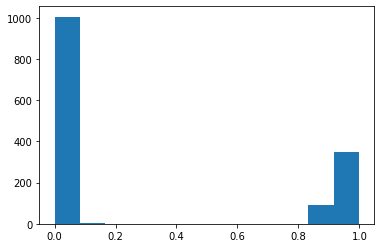

In [614]:

#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet+strategy')]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet')]
#filtered_orderbook = orderbook[(orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='fbProphet') | (orderbook['type']==strategy)]
#filtered_orderbook = orderbook[(orderbook['type']=='MACD') & (orderbook['estRet']>=.04)]

filtered_orderbook = orderbook[((orderbook['type']=='MACD') & (orderbook['estRet']>=.04) )| ((orderbook['type']=='fbProphet') | (orderbook['type']==strategy) |((orderbook['type']=='H') & (orderbook['estRet']>=1) )|( (orderbook['type']=='adf') & (orderbook['estRet']>=.9)) )]
#filtered_orderbook = filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)
#display(filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True))
#display(filtered_orderbook)

plt.hist(filtered_orderbook['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram
#plt.hist(orderbook[orderbook['type']=='adf']['estRet'].dropna(), bins='auto')  # arguments are passed to np.histogram

In [615]:
filtered_orderbook

date  dateBought dateToBeSold  estRet orderside       type  \
0     2016-09-12  2016-09-12   2016-09-21  0.0148       buy  fbProphet   
3     2016-09-12  2016-09-12   2016-09-21  0.0085       buy        SMA   
5     2016-09-13  2016-09-13   2016-09-22  0.0221       buy  fbProphet   
8     2016-09-13  2016-09-13   2016-09-22  0.0084       buy        SMA   
10    2016-09-14  2016-09-14   2016-09-23  0.0146       buy  fbProphet   
13    2016-09-14  2016-09-14   2016-09-23  0.0081       buy        SMA   
15    2016-09-15  2016-09-15   2016-09-26  0.0002       buy  fbProphet   
18    2016-09-15  2016-09-15   2016-09-26  0.0081       buy        SMA   
20    2016-09-16  2016-09-16   2016-09-27  0.0032       buy  fbProphet   
23    2016-09-16  2016-09-16   2016-09-27  0.0084       buy        SMA   
25    2016-09-19  2016-09-19   2016-09-28  0.0062       buy  fbProphet   
28    2016-09-20  2016-09-20   2016-09-29  0.0085       buy  fbProphet   
33    2016-09-21  2016-09-21   2016-09-30  0.0084       buy        SMA   
34    2016-09-22  2016-09-22   2016-10-03  0.0031       buy  fbProphet   
37    2016-09-23  2016-09-23   2016-10-04  0.0115       buy  fbProphet   
40    2016-09-26  2016-09-26   2016-10-05  0.0287       buy  fbProphet   
43    2016-09-27  2016-09-27   2016-10-06  0.0224       buy  fbProphet   
46    2016-09-28  2016-09-28   2016-10-07  0.0200       buy  fbProphet   
49    2016-09-29  2016-09-29   2016-10-10  0.0302       buy  fbProphet   
52    2016-09-29  2016-09-29   2016-10-10  0.0083       buy        SMA   
54    2016-09-30  2016-09-30   2016-10-11  0.0223       buy  fbProphet   
57    2016-09-30  2016-09-30   2016-10-11  0.0080       buy        SMA   
59    2016-10-03  2016-10-03   2016-10-12  0.0266       buy  fbProphet   
62    2016-10-04  2016-10-04   2016-10-13  0.0334       buy  fbProphet   
65    2016-10-04  2016-10-04   2016-10-13  0.0081       buy        SMA   
67    2016-10-05  2016-10-05   2016-10-14  0.0302       buy  fbProphet   
70    2016-10-06  2016-10-06   2016-10-17  0.0376       buy  fbProphet   
73    2016-10-07  2016-10-07   2016-10-18  0.0392       buy  fbProphet   
76    2016-10-07  2016-10-07   2016-10-18  0.0079       buy        SMA   
78    2016-10-10  2016-10-10   2016-10-19  0.0336       buy  fbProphet   
81    2016-10-11  2016-10-11   2016-10-20  0.0448       buy  fbProphet   
84    2016-10-11  2016-10-11   2016-10-20  0.0080       buy        SMA   
86    2016-10-12  2016-10-12   2016-10-21  0.0370       buy  fbProphet   
89    2016-10-13  2016-10-13   2016-10-24  0.0401       buy  fbProphet   
92    2016-10-13  2016-10-13   2016-10-24  0.0074       buy        SMA   
94    2016-10-14  2016-10-14   2016-10-25  0.0228       buy  fbProphet   
97    2016-10-14  2016-10-14   2016-10-25  0.0074       buy        SMA   
99    2016-10-17  2016-10-17   2016-10-26  0.0215       buy  fbProphet   
102   2016-10-18  2016-10-18   2016-10-27  0.0260       buy  fbProphet   
105   2016-10-19  2016-10-19   2016-10-28  0.0278       buy  fbProphet   
108   2016-10-20  2016-10-20   2016-10-31  0.0222       buy  fbProphet   
111   2016-10-21  2016-10-21   2016-11-01  0.0149       buy  fbProphet   
114   2016-10-21  2016-10-21   2016-11-01  0.0071       buy        SMA   
116   2016-10-24  2016-10-24   2016-11-02  0.0060       buy  fbProphet   
119   2016-10-25  2016-10-25   2016-11-03  0.0112       buy  fbProphet   
122   2016-10-26  2016-10-26   2016-11-04  0.0090       buy  fbProphet   
125   2016-10-27  2016-10-27   2016-11-07  0.0008       buy  fbProphet   
130   2016-10-28  2016-10-28   2016-11-08  0.0071       buy        SMA   
133   2016-11-01  2016-11-01   2016-11-10  0.0099       buy  fbProphet   
136   2016-11-01  2016-11-01   2016-11-10  0.0070       buy        SMA   
138   2016-11-02  2016-11-02   2016-11-11  0.0162       buy  fbProphet   
140   2016-11-02  2016-11-02   2016-11-11  0.0070       buy        SMA   
142   2016-11-03  2016-11-03   2016-11-14  0.0198       buy  fbProphet   
144   2016-11-04

In [616]:
len(filtered_orderbook)

1446

In [617]:
filtered_orderbook.sort_values(by=['date','orderside','type'], ascending=True)

date  dateBought dateToBeSold  estRet orderside       type  \
3     2016-09-12  2016-09-12   2016-09-21  0.0085       buy        SMA   
0     2016-09-12  2016-09-12   2016-09-21  0.0148       buy  fbProphet   
8     2016-09-13  2016-09-13   2016-09-22  0.0084       buy        SMA   
5     2016-09-13  2016-09-13   2016-09-22  0.0221       buy  fbProphet   
13    2016-09-14  2016-09-14   2016-09-23  0.0081       buy        SMA   
10    2016-09-14  2016-09-14   2016-09-23  0.0146       buy  fbProphet   
18    2016-09-15  2016-09-15   2016-09-26  0.0081       buy        SMA   
15    2016-09-15  2016-09-15   2016-09-26  0.0002       buy  fbProphet   
23    2016-09-16  2016-09-16   2016-09-27  0.0084       buy        SMA   
20    2016-09-16  2016-09-16   2016-09-27  0.0032       buy  fbProphet   
25    2016-09-19  2016-09-19   2016-09-28  0.0062       buy  fbProphet   
28    2016-09-20  2016-09-20   2016-09-29  0.0085       buy  fbProphet   
33    2016-09-21  2016-09-21   2016-09-30  0.0084       buy        SMA   
2142  2016-09-21  2016-09-12   2016-09-21  0.0085      sell        SMA   
2141  2016-09-21  2016-09-12   2016-09-21  0.0148      sell  fbProphet   
34    2016-09-22  2016-09-22   2016-10-03  0.0031       buy  fbProphet   
2147  2016-09-22  2016-09-13   2016-09-22  0.0084      sell        SMA   
2146  2016-09-22  2016-09-13   2016-09-22  0.0221      sell  fbProphet   
37    2016-09-23  2016-09-23   2016-10-04  0.0115       buy  fbProphet   
2152  2016-09-23  2016-09-14   2016-09-23  0.0081      sell        SMA   
2151  2016-09-23  2016-09-14   2016-09-23  0.0146      sell  fbProphet   
40    2016-09-26  2016-09-26   2016-10-05  0.0287       buy  fbProphet   
2157  2016-09-26  2016-09-15   2016-09-26  0.0081      sell        SMA   
2156  2016-09-26  2016-09-15   2016-09-26  0.0002      sell  fbProphet   
43    2016-09-27  2016-09-27   2016-10-06  0.0224       buy  fbProphet   
2162  2016-09-27  2016-09-16   2016-09-27  0.0084      sell        SMA   
2161  2016-09-27  2016-09-16   2016-09-27  0.0032      sell  fbProphet   
46    2016-09-28  2016-09-28   2016-10-07  0.0200       buy  fbProphet   
2166  2016-09-28  2016-09-19   2016-09-28  0.0062      sell  fbProphet   
52    2016-09-29  2016-09-29   2016-10-10  0.0083       buy        SMA   
49    2016-09-29  2016-09-29   2016-10-10  0.0302       buy  fbProphet   
2169  2016-09-29  2016-09-20   2016-09-29  0.0085      sell  fbProphet   
57    2016-09-30  2016-09-30   2016-10-11  0.0080       buy        SMA   
54    2016-09-30  2016-09-30   2016-10-11  0.0223       buy  fbProphet   
2172  2016-09-30  2016-09-21   2016-09-30  0.0084      sell        SMA   
59    2016-10-03  2016-10-03   2016-10-12  0.0266       buy  fbProphet   
2175  2016-10-03  2016-09-22   2016-10-03  0.0031      sell  fbProphet   
65    2016-10-04  2016-10-04   2016-10-13  0.0081       buy        SMA   
62    2016-10-04  2016-10-04   2016-10-13  0.0334       buy  fbProphet   
2178  2016-10-04  2016-09-23   2016-10-04  0.0115      sell  fbProphet   
67    2016-10-05  2016-10-05   2016-10-14  0.0302       buy  fbProphet   
2181  2016-10-05  2016-09-26   2016-10-05  0.0287      sell  fbProphet   
70    2016-10-06  2016-10-06   2016-10-17  0.0376       buy  fbProphet   
2184  2016-10-06  2016-09-27   2016-10-06  0.0224      sell  fbProphet   
76    2016-10-07  2016-10-07   2016-10-18  0.0079       buy        SMA   
73    2016-10-07  2016-10-07   2016-10-18  0.0392       buy  fbProphet   
2187  2016-10-07  2016-09-28   2016-10-07  0.0200      sell  fbProphet   
78    2016-10-10  2016-10-10   2016-10-19  0.0336       buy  fbProphet   
2191  2016-10-10  2016-09-29   2016-10-10  0.0083      sell        SMA   
2190  2016-10-10  2016-09-29   2016-10-10  0.0302      sell  fbProphet   
84    2016-10-11  2016-10-11   2016-10-20  0.0080       buy        SMA   
81    2016-10-11  2016-10-11   2016-10-20  0.0448       buy  fbProphet   
2196  2016-10-11  2016-09-30   2016-10-11  0.0080      sell        SMA   
2195  2016-10-11

In [618]:

funds = 1000
BuyFundsPercent = 1
percentHeldOnSell = 1

buyLog = pd.DataFrame()
sellLog = pd.DataFrame()
runningLog = pd.DataFrame()

held = 0
upper = 0
lower = 0

#weights = [3,2,1]

#weights2 = 1/np.array(weights)/sum(1/np.array(weights))

weights2 = [.125, .25, .5, .75]

for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
    
    
    temp = pd.DataFrame()
    rtemp = pd.DataFrame()
    _temp = pd.DataFrame()
    
    t = i.strftime('%Y-%m-%d')
    
    subset = filtered_orderbook[filtered_orderbook['date']==t]
        
    gain = 0
    paid = 0

    if len(subset) != 0:
        print()
        print("date " + str(i))
        print(subset)
        
        sales = subset[subset['orderside'] == 'sell']        
        types_s = sales['type'].unique()
        
        for ts_ in types_s:
            
            sales_t = sales[sales['type']==ts_]

            if len(sales_t) != 0:                        

                oldvalue = sales_t['valueAtPurchase'].values[0]

                newvalue = sales_t['valueAtSale'].values[0]      
                
                bl = buyLog.set_index('date').loc[datetime.datetime.strptime(sales_t['dateBought'].values[0], "%Y-%m-%d").date()]
                #buyLog.set_index('date').loc[sales_t['dateBought'].values[0]]
                
                if isinstance(bl, pd.Series):
                    bl = pd.DataFrame(bl).transpose()
                
                Qty = bl[bl['type']==ts_]['qty'][0]
                    
                gain = gain + (newvalue * Qty)

                _temp['date'] = [i]
                _temp['type'] = [ts_]
                _temp['qty'] = [Qty]
                
                sellLog = pd.concat([sellLog,_temp])                
    
        purchases = subset[subset['orderside'] == 'buy']
        
        types_p = purchases['type'].unique()
        
        for tp in types_p:
            
            purchases_t = purchases[purchases['type']==tp]

            if len(purchases_t) != 0:
                
                weights = [3,2,1]                

                #print(tp)
                if tp == 'adf': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                if tp == 'H': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                if tp == 'MACD': BuyFundsPercent_ = BuyFundsPercent * weights2[1]                
                if tp == strategy: BuyFundsPercent_ = BuyFundsPercent * weights2[2]
                if tp == 'fbProphet': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                if tp == 'fbProphet+strategy': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                
                ProportionOfFunds = funds * BuyFundsPercent_

                Qty = ProportionOfFunds / purchases_t['valueAtPurchase'].values[0]
                Qty = Qty.round(6)
                #print(purchases['valueAtPurchase'].values[0])
                #print("Qty purchased " + str(Qty.round(2)))

                temp['date'] = [i]
                temp['type'] = [tp]
                temp['qty'] = [Qty]

                paid = purchases_t['valueAtPurchase'].values[0]*Qty
                
                print("buy")
                print(temp)

                buyLog = pd.concat([buyLog,temp])

                #print(buyLog)
                
                funds = funds - paid           

        funds = funds + gain
        
        rtemp['date'] =  [i]
        rtemp['funds'] =  [funds]
        
        if len(sellLog) != 0:
            remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            
            
        else:
            remainder = (sum(buyLog['qty']))
        
        rtemp['held'] = remainder
        
        #print(remainder)
        rtemp['value'] = remainder * data.loc[i]['Close']
        rtemp['portValue'] = funds + remainder * data.loc[i]['Close']
        #print(rtemp)
                
        #print("in " + str(gain))
        #print("out " + str(paid))
        #print("held: " + str(remainder))
        #print("Close Value: " + str(data.loc[i]['Close']))
        #print("held Value: " + str(remainder * data.loc[i]['Close']))
        #print("funds " + str(funds))
        #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
        #print()
            
        runningLog = runningLog.append(rtemp)
        
funds = 1000                                                    
                


date 2016-09-12 00:00:00
         date  dateBought dateToBeSold  estRet orderside       type  \
0  2016-09-12  2016-09-12   2016-09-21  0.0148       buy  fbProphet   
3  2016-09-12  2016-09-12   2016-09-21  0.0085       buy        SMA   

   valueAtPurchase  valueAtSale  
0           198.46       198.99  
3           198.46       198.99  
buy
        date       type       qty
0 2016-09-12  fbProphet  3.779099
buy
        date type      qty
0 2016-09-12  SMA  0.62985

date 2016-09-13 00:00:00
         date  dateBought dateToBeSold  estRet orderside       type  \
5  2016-09-13  2016-09-13   2016-09-22  0.0221       buy  fbProphet   
8  2016-09-13  2016-09-13   2016-09-22  0.0084       buy        SMA   

   valueAtPurchase  valueAtSale  
5           195.61       200.24  
8           195.61       200.24  
buy
        date       type      qty
0 2016-09-13  fbProphet  0.47927
buy
        date type       qty
0 2016-09-13  SMA  0.079878

date 2016-09-14 00:00:00
          date  dateBought dat

In [619]:
#sellLog['orderSide'] = 'sale'
#sellLog['cumsum'] = cumsum(sellLog['qty'])
#buyLog['orderSide'] = 'buy'
#buyLog['cumsum'] = cumsum(buyLog['qty'])

In [620]:
len(orderbook[orderbook['orderside']=='buy'])-len(orderbook[orderbook['orderside']=='sell'])

0

In [621]:
runningLog

date        funds          held         value    portValue
0 2016-09-12   124.999981  4.408949e+00  8.750000e+02  1000.000000
0 2016-09-13    15.625041  4.968097e+00  9.718095e+02   987.434495
0 2016-09-14     1.953080  5.038016e+00  9.851336e+02   987.086729
0 2016-09-15     0.244199  5.046669e+00  9.966667e+02   996.910860
0 2016-09-16     0.030550  5.047755e+00  9.930448e+02   993.075391
0 2016-09-19     0.007726  5.047871e+00  9.932191e+02   993.226824
0 2016-09-20     0.002020  5.047900e+00  9.932753e+02   993.277303
0 2016-09-21   877.337786  6.389560e-01  1.271459e+02  1004.483641
0 2016-09-22   331.298324  3.365881e+00  6.739840e+02  1005.282336
0 2016-09-23    96.748245  4.543696e+00  9.048316e+02  1001.579867
0 2016-09-26    25.896209  4.902386e+00  9.683683e+02   994.264516
0 2016-09-27     6.689832  4.999017e+00  9.936046e+02  1000.294451
0 2016-09-28     1.695533  5.024021e+00  1.003498e+03  1005.193487
0 2016-09-29     0.217713  5.031487e+00  9.959325e+02   996.150250
0 2016-09-30     0.028254  5.032437e+00  1.003619e+03  1003.647165
0 2016-10-03   653.771190  1.746471e+00  3.474604e+02  1001.231596
0 2016-10-04   328.697891  3.388753e+00  6.707698e+02   999.467660
0 2016-10-05   155.205947  4.261405e+00  8.472099e+02  1002.415875
0 2016-10-06    58.242293  4.748782e+00  9.447702e+02  1003.012472
0 2016-10-07    12.260902  4.980695e+00  9.875224e+02   999.783300
0 2016-10-10     4.558954  5.019340e+00  1.000354e+03  1004.913416
0 2016-10-11     0.757754  5.038657e+00  9.915069e+02   992.264679
0 2016-10-12     0.210574  5.041434e+00  9.933642e+02   993.574730
0 2016-10-13   567.625494  2.152356e+00  4.227227e+02   990.348212
0 2016-10-14   314.612094  3.439956e+00  6.759514e+02   990.563448
0 2016-10-17   193.220272  4.059903e+00  7.949696e+02   988.189878
0 2016-10-18    98.950818  4.538331e+00  8.942327e+02   993.183559
0 2016-10-19    33.853677  4.867820e+00  9.617352e+02   995.588874
0 2016-10-20    12.461026  4.976302e+00  9.813268e+02   993.787781
0 2016-10-21     2.126581  5.028684e+00  9.921091e+02   994.235648
0 2016-10-24     0.717481  5.035796e+00  9.977423e+02   998.459742
0 2016-10-25   499.278311  2.510926e+00  4.958074e+02   995.085759
0 2016-10-26   362.296925  3.206016e+00  6.318096e+02   994.106498
0 2016-10-27   235.121787  3.853086e+00  7.572855e+02   992.407309
0 2016-10-28   191.169135  4.077380e+00  7.990034e+02   990.172520
0 2016-10-31   216.401056  3.948626e+00  7.738122e+02   990.213293
0 2016-11-01    37.802211  4.866636e+00  9.468040e+02   984.606244
0 2016-11-02     6.282044  5.029632e+00  9.726302e+02   978.912280
0 2016-11-03     2.095169  5.051382e+00  9.723910e+02   974.486204
0 2016-11-04   365.619160  3.160785e+00  6.077557e+02   973.374900
0 2016-11-07   317.397476  3.406163e+00  6.693792e+02   986.776629
0 2016-11-08   158.105570  4.213072e+00  8.317025e+02   989.808114
0 2016-11-09    79.052698  4.609327e+00  9.195607e+02   998.613434
0 2016-11-10   204.536698  3.981907e+00  7.963814e+02  1000.918098
0 2016-11-11    59.697595  4.707772e+00  9.393888e+02   999.086420
0 2016-11-14    19.812114  4.907499e+00  9.800276e+02   999.839664
0 2016-11-15    21.730831  4.897965e+00  9.857155e+02  1007.446287
0 2016-11-16   332.446993  3.351190e+00  6.731870e+02  1005.634040
0 2016-11-17   367.165216  3.179241e+00  6.419206e+02  1009.085766
0 2016-11-18   171.620887  4.149877e+00  8.360342e+02  1007.655108
0 2016-11-21   113.107031  4.438151e+00  9.008559e+02  1013.962921
0 2016-11-22   210.681516  3.958363e+00  8.050123e+02  1015.693799
0 2016-11-23    98.293175  4.510667e+00  9.178756e+02  1016.168803
0 2016-11-25    24.573360  4.871614e+00  9.949784e+02  1019.551803
0 2016-11-28    22.636305  4.881143e+00  9.922387e+02  1014.875054
0 2016-11-29   257.180139  3.729612e+00  7.596474e+02  1016.827511
0 2016-11-30   309.886203  3.470219e+00  7.051138e+02  1015.000001
0 2016-12-01   205.844796  3.984156e+00  8.065525e+02  1012.397337
0 2016-12-02   290.333060  3.567033e+00  7.225025e+02  

In [622]:
#new = sellLog.append(buyLog).sort_values(by=['date'], ascending=True)
#new[new['orderSide']=='sale']
#new

In [623]:
if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].strftime('%Y-%m-%d'):
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date]
    rl_temp['funds'] = [runningLog.iloc[-1]['funds']]
    rl_temp['held'] = [runningLog.iloc[-1]['held']]
    rl_temp['value'] = [runningLog.iloc[-1]['value']]
    rl_temp['portValue'] = [runningLog.iloc[-1]['portValue']]
    runningLog = runningLog.append(rl_temp)
    
    runningLog = runningLog.sort_values(by=['date'], ascending=True)
    
if end_date1.strftime('%Y-%m-%d') != runningLog['date'].iloc[0].strftime('%Y-%m-%d'):
    rl_temp = pd.DataFrame()
    rl_temp['date'] = [end_date1]
    rl_temp['funds'] = [funds]
    rl_temp['held'] = [0]
    rl_temp['value'] = [0]
    rl_temp['portValue'] = [funds]
    runningLog = runningLog.append(rl_temp)

    runningLog = runningLog.sort_values(by=['date'], ascending=True)


Date                Type    expRet      sdev
0  2016-09-12           fbProphet  0.014779       NaN
0  2016-09-12                MACD  0.012162       NaN
0  2016-09-12                 adf  0.163696       NaN
0  2016-09-12                 SMA  0.008513  0.022004
0  2016-09-12  fbProphet+strategy  0.011646       NaN
0  2016-09-13           fbProphet  0.022113       NaN
0  2016-09-13                MACD  0.011061       NaN
0  2016-09-13                 adf  0.130564       NaN
0  2016-09-13                 SMA  0.008351  0.022020
0  2016-09-13  fbProphet+strategy  0.015232       NaN
0  2016-09-14           fbProphet  0.014568       NaN
0  2016-09-14                MACD  0.009978       NaN
0  2016-09-14                 adf  0.142798       NaN
0  2016-09-14                 SMA  0.008133  0.022029
0  2016-09-14  fbProphet+strategy  0.011351       NaN
0  2016-09-15           fbProphet  0.000208       NaN
0  2016-09-15                MACD  0.009021       NaN
0  2016-09-15                 adf  0.167733       NaN
0  2016-09-15                 SMA  0.008143  0.022029
0  2016-09-15  fbProphet+strategy  0.004175       NaN
0  2016-09-16           fbProphet  0.003167       NaN
0  2016-09-16                MACD  0.008135       NaN
0  2016-09-16                 adf  0.160711       NaN
0  2016-09-16                 SMA  0.008376  0.022032
0  2016-09-16  fbProphet+strategy  0.005772       NaN
0  2016-09-19           fbProphet  0.006227       NaN
0  2016-09-19                MACD  0.007370       NaN
0  2016-09-19                 adf  0.159934       NaN
0  2016-09-20           fbProphet  0.008475       NaN
0  2016-09-20                MACD  0.006712       NaN
0  2016-09-20                 adf  0.147698       NaN
0  2016-09-21                MACD  0.006188       NaN
0  2016-09-21                 adf  0.187131       NaN
0  2016-09-21                 SMA  0.008350  0.022028
0  2016-09-22           fbProphet  0.003076       NaN
0  2016-09-22                MACD  0.005794       NaN
0  2016-09-22                 adf  0.207117       NaN
0  2016-09-23           fbProphet  0.011520       NaN
0  2016-09-23                MACD  0.005478       NaN
0  2016-09-23                 adf  0.191173       NaN
0  2016-09-26           fbProphet  0.028674       NaN
0  2016-09-26                MACD  0.005182       NaN
0  2016-09-26                 adf  0.164355       NaN
0  2016-09-27           fbProphet  0.022403       NaN
0  2016-09-27                MACD  0.004941       NaN
0  2016-09-27                 adf  0.195976       NaN
0  2016-09-28           fbProphet  0.020017       NaN
0  2016-09-28                MACD  0.004780       NaN
0  2016-09-28                 adf  0.215092       NaN
0  2016-09-29           fbProphet  0.030154       NaN
0  2016-09-29                MACD  0.004598       NaN
0  2016-09-29                 adf  0.193522       NaN
0  2016-09-29                 SMA  0.008297  0.022034
0  2016-09-29  fbProphet+strategy  0.019225       NaN
0  2016-09-30           fbProphet  0.022261       NaN
0  2016-09-30                MACD  0.004489       NaN
0  2016-09-30                 adf  0.210805       NaN
0  2016-09-30                 SMA  0.008043  0.022042
0  2016-09-30  fbProphet+strategy  0.015152       NaN
0  2016-10-03           fbProphet  0.026593       NaN
0  2016-10-03                MACD  0.004405       NaN
0  2016-10-03                 adf  0.189181       NaN
0  2016-10-04           fbProphet  0.033354       NaN
0  2016-10-04                MACD  0.004277       NaN
0  2016-10-04                 adf  0.182328       NaN
0  2016-10-04                 SMA  0.008137  0.022050
0  2016-10-04  fbProphet+strategy  0.020745       NaN
0  2016-10-05           fbProphet  0.030170       NaN
0  2016-10-05                MACD  0.004175       NaN
0  2016-10-05                 adf  0.186833       NaN
0  2016-10-06           fbProphet  0.037649       NaN
0  2016-10-06                MACD  0.004098       NaN
0  2016-10-06                 adf  0.191592       NaN
0  2016-10-07

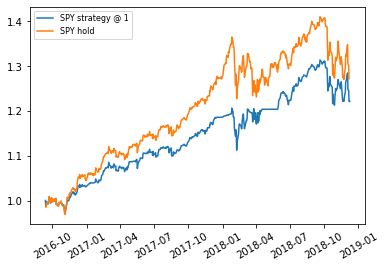

1.2214579489599833


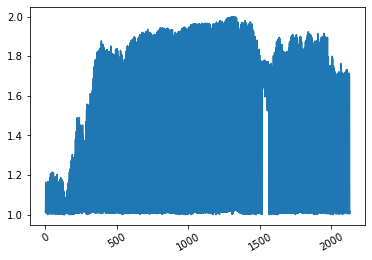

1.2214579489599833
0.20986978564169534


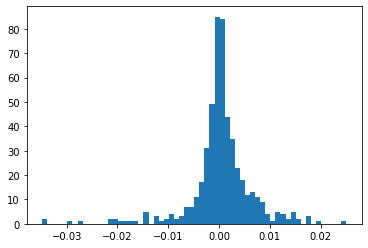

In [625]:

ret_data =  runningLog.set_index('date')['portValue'].pct_change()
cumulative_ret_data = (ret_data + 1).cumprod()

ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
cum_ret_data2 = (ret_data2 + 1).cumprod()

sp500_data = benchData[runningLog.set_index('date').index[1]:]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()

plt.plot(cumulative_ret_data,label=name + " strategy @ " + str(BuyFundsPercent) )
plt.plot(cum_ret_data2,label=name + " hold")
#plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)
plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 

plt.show()

print(cumulative_ret_data[-1])

plt.plot((set['ExpectedReturn']+1))
plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

runningLog

plt.show()
print(cumulative_ret_data.iloc[-1])
plt.hist(runningLog.set_index('date')['portValue'].pct_change().dropna(), bins='auto')  # arguments are passed to np.histogram
print(runningLog['portValue'].dropna().pct_change().sum())

